In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
%matplotlib inline

# Generate Data

In [2]:
# Parameters of 'true' model
np.random.seed(4)
slope = 2.3
intercept = 0.1
beta_true = np.array([intercept, slope])

def func(x, beta=beta_true):
    return beta[0] + beta[1]*x

In [3]:
# Variance (precision) in the data
var_1 = 2 # coarse
var_2 = 0.2 # fine

w_1 = 1/var_1
w_2 = 1/var_2

# Number of data points
N = 20

# Fraction of data points that are coarse/fine
coarse = int(0.75*N)
fine = N - coarse

# Data without noise
x = stats.uniform.rvs(loc=0, scale=5, size=N)
y_obs = func(x)

# Arrays for storing std/precision (used later for weighted least squares and Bayesian inversion)
sigma = np.zeros(len(x))
w = np.zeros(len(x))

# Add coarse random normal noise
y_obs[0:coarse] = y_obs[0:coarse] + stats.norm.rvs(scale=var_1, size=coarse)
# Assign coarse std/precision over same range
sigma[0:coarse] = np.sqrt(var_1)
w[0:coarse] = w_1 

# Add fine random normal noise
y_obs[coarse:] = y_obs[coarse:] + stats.norm.rvs(scale=var_2, size=fine)
# Assign fine std/precision over same range
sigma[coarse:] = np.sqrt(var_2)
w[coarse:] = w_2 

# For plotting coarse and fine data seperately
x_fine = x[coarse:]
x_coarse = x[0:coarse]
y_fine = y_obs[coarse:]
y_coarse = y_obs[0:coarse]

# For plotting true line
x_hat = np.linspace(0, 5, num=10)
y_true = func(x_hat)

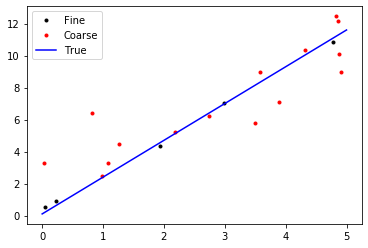

In [4]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

# Linear Regression (OLS)

Data is described by simple model:
$$ y = a + bx$$

In [5]:
b_lr, a_lr, r_lr, p_lr, std_err_lr = stats.linregress(x, y_obs)

In [6]:
y_lr = func(x_hat, beta=np.array([a_lr, b_lr]))

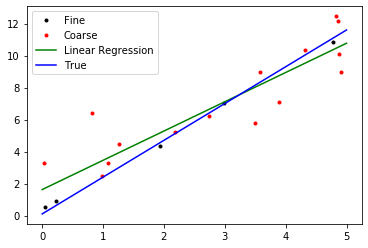

In [7]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_lr, '-g', label='Linear Regression')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

## Linear Regression / Ordinary Least Squares / Minmize Residual Sum of Squared Errrors for a Linear Model

Statistical model:
    $$y_i = \hat{y}_i + e_i; \hspace{10pt} e \sim N(0, \sigma^2)$$
    $$\hat{y}_i = a + b x_i$$

Define a loss function based on the residual sum of squared errors:
    $$L(y_i, \hat{y}_i) = (y_i - \hat{y}_i)^2 = (y_i - (a + b x_i))^2$$
    $$L(\mathbf{y}, \mathbf{\hat{y}}) = \sum_{i=1}^N (y_i - (a + b x_i))^2$$

We would like to find parameters $a$ and $b$ that minimize this loss function. This represents the best fit to the data.

To do this we take partial derivatives of the loss wrt to $a$ and $b$ and set the results equal to zero:

$$ \frac{\partial L}{\partial a} = 0 $$

$$ \frac{\partial L}{\partial b} = 0 $$

The partial derivatives of the loss are calculated using chain rule:

$$ \frac{\partial L}{\partial a} = \sum_{i=1}^N 2 (y_i - a - b x_i)(-1) = -2 \sum_{i=1}^N (y_i - a - b x_i) $$
$$ \frac{\partial L}{\partial b} = \sum_{i=1}^N 2 (y_i - a - b x_i)(x_i) = 2 \sum_{i=1}^N (y_i x_i - a x_i - b x_i^2) $$

Expanding and setting equal to zero:

$$ \frac{\partial L}{\partial a} = -2 \left( \sum_{i=1}^N y_i \right) + 2aN + 2b \left( \sum_{i=1}^n x_i \right) = 0 $$
$$ \frac{\partial L}{\partial b} = 2 \left( \sum_{i=1}^N y_i x_i \right) - 2 a \left( \sum_{i=1}^N x_i \right) - 2b \left( \sum_{i=1}^N x_i^2 \right) = 0$$

Solving the system for $a$ and $b$:

$$a = \frac{\left( \sum_{i=1}^N x_i^2 \right) \left( \sum_{i=1}^N y_i \right) - \left( \sum_{i=1}^n x_i \right) \left( \sum_{i=1}^N y_i x_i \right)}{N \left( \sum_{i=1}^N x_i^2 \right) - \left( \sum_{i=1}^n x_i \right)^2}$$

$$b = \frac{N \left( \sum_{i=1}^N y_i x_i \right) - \left( \sum_{i=1}^n x_i \right) \left( \sum_{i=1}^N y_i \right)}{N \left( \sum_{i=1}^N x_i^2 \right) - \left( \sum_{i=1}^n x_i \right)^2}$$

In [8]:
a_ls = ((x**2).sum()*y_obs.sum() - x.sum()*(y_obs*x).sum())/(N*(x**2).sum() - (x.sum())**2)
b_ls = (N*(y_obs*x).sum() - x.sum()*y_obs.sum())/(N*(x**2).sum() - (x.sum())**2)

In [9]:
print(a_lr, a_ls)
print(b_lr, b_ls)

1.6217381508530346 1.6217381508530337
1.8298534393823453 1.8298534393823445


In [10]:
y_ls = func(x_hat, beta=np.array([a_ls, b_ls]))

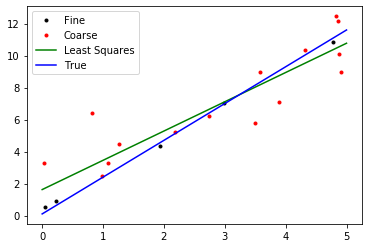

In [11]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_ls, '-g', label='Least Squares')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

## LR / OLS / RSSe in Matrix Form

Re-organizing the model in vector form:
    $$y_i = \hat{y}_i + e_i; \hspace{10pt} e \sim N(0, \sigma^2)$$
    $$\hat{y}_i = a + b x_i$$
    $$\begin{bmatrix}
        \hat{y_1} \\
        \hat{y_2} \\
        \vdots \\
        \hat{y_n}
      \end{bmatrix} =
      a \cdot
      \begin{bmatrix}
          1 \\
          1 \\
          \vdots \\
          1 
      \end{bmatrix} + 
      b \cdot
      \begin{bmatrix}
          x_1 \\
          x_2 \\
          \vdots \\
          x_n
      \end{bmatrix}
    $$

Re-arranging:
    $$\begin{bmatrix}
        \hat{y_1} \\
        \hat{y_2} \\
        \vdots \\
        \hat{y_n}
      \end{bmatrix} =
      \begin{bmatrix}
          1 & x_1\\
          1 & x_2 \\
          \vdots & \vdots \\
          1 & x_n
      \end{bmatrix} \cdot 
      \begin{bmatrix}
          a \\
          b \\
      \end{bmatrix}
    $$

Vector-matrix form:
    $$ \mathbf{\hat{y}} = \mathbf{X \beta}$$

In [12]:
# Create X matrix and X_hat matrix
X = np.column_stack((np.ones(len(x)), x))
X_hat = np.column_stack((np.ones(len(x_hat)), x_hat))

The loss function is then:
    $$L(\mathbf{y}, \mathbf{\hat{y}}) = (\mathbf{y} - \mathbf{X \beta})^T (\mathbf{y} - \mathbf{X \beta})$$
Expanding:
    $$L(\mathbf{y}, \mathbf{\hat{y}}) = \mathbf{y^T y - y^T X \beta - \beta^T X^T y + \beta^T X^T X \beta}$$

We would like to find the $\mathbf{\beta}$ that minimizes this loss function. This represents the best fit to the data.

To do this we take partial derivatives of the loss wrt to $\beta$ and set the result equal to zero:
    $$\frac{\partial L}{\partial \mathbf{\beta}} = 0$$

The derivative of the loss is:
    $$\frac{\partial L}{\partial \mathbf{\beta}} = \frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{y^T y - y^T X \beta - \beta^T X^T y + \beta^T X^T X \beta}\right)$$
    $$\frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{y^T y} \right)=\mathbf{0}$$
    $$\frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{y^T X \beta} \right)=\mathbf{y^T X} = \mathbf{X^T y} $$
    $$\frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{\beta^T X^T y} \right)= \mathbf{X^T y} $$
    $$\frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{\beta^T X^T X \beta} \right) = 2 \mathbf{X^T X \beta}$$
    
Plugging in and setting equal to zero:
    $$\frac{\partial L}{\partial \mathbf{\beta}} = -2 \mathbf{X^T y} + 2 \mathbf{X^T X \beta} = \mathbf{0}$$
Solving for $\mathbf{\beta}$:
    $$\mathbf{X^T X \beta} = \mathbf{X^T y}$$
    $$\mathbf{\beta} = \mathbf{(X^T X)^{-1} X^T y}$$

In [13]:
beta_ls = np.linalg.inv(X.T @ X)@ (X.T @ y_obs)
y_mls = func(x_hat, beta=beta_ls)

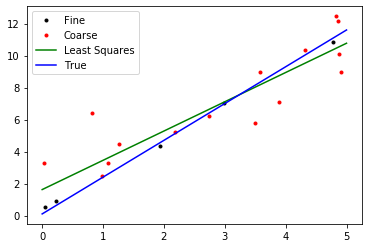

In [14]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_mls, '-g', label='Least Squares')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

# Maximum Likelihood

# Weighted Least Squares

Statistical model:
    $$y_i = \hat{y}_i + e_i; \hspace{10pt} e_i \sim N(0, \sigma_i^2)$$
    $$\hat{y}_i = a + b x_i$$

Define a loss function based on the residual sum of squared errors:
    $$L(y_i, \hat{y}_i) = (y_i - \hat{y}_i)^2 = w_i (y_i - (a + b x_i))^2; \hspace{10pt} w_i = \frac{1}{\sigma_i^2}$$
    $$L(\mathbf{y}, \mathbf{\hat{y}}) = \sum_{i=1}^N w_i (y_i - (a + b x_i))^2$$

We would like to find parameters $a$ and $b$ that minimize this loss function. This represents the best fit to the data.

To do this we take partial derivatives of the loss wrt to $a$ and $b$ and set the results equal to zero:

$$ \frac{\partial L}{\partial a} = 0 $$

$$ \frac{\partial L}{\partial b} = 0 $$

The partial derivatives of the loss are calculated using chain rule:

$$ \frac{\partial L}{\partial a} = \sum_{i=1}^N 2 w_i (y_i - a - b x_i)(-1) = -2 \sum_{i=1}^N w_i (y_i - a - b x_i) $$
$$ \frac{\partial L}{\partial b} = \sum_{i=1}^N 2 w_i (y_i - a - b x_i)(x_i) = 2 \sum_{i=1}^N w_i (y_i x_i - a x_i - b x_i^2) $$

Expanding and setting equal to zero:

$$ \frac{\partial L}{\partial a} = \sum_{i=1}^N w_i y_i - a \sum_{i=1}^N w_i - b \sum_{i=1}^n w_i x_i = 0 $$
$$ \frac{\partial L}{\partial b} =  \sum_{i=1}^N w_i y_i x_i - a \sum_{i=1}^N w_i x_i - b \sum_{i=1}^N w_i x_i^2 = 0 $$

Solving the system for $a$ and $b$:

$$a = \frac{\left( \sum_{i=1}^N w_i x_i^2 \right) \left( \sum_{i=1}^N w_i y_i \right) - \left( \sum_{i=1}^n w_i x_i \right) \left( \sum_{i=1}^N w_i y_i x_i \right)}{\left(\sum_{i=1}^N w_i \right) \left( \sum_{i=1}^N x_i^2 \right) - \left( \sum_{i=1}^n w_i x_i \right)^2}$$

$$b = \frac{\left(\sum_{i=1}^N w_i \right) \left( \sum_{i=1}^N w_i y_i x_i \right) - \left( \sum_{i=1}^n w_i x_i \right) \left( \sum_{i=1}^N w_i y_i \right)}{\left(\sum_{i=1}^N w_i \right) \left( \sum_{i=1}^N w_i x_i^2 \right) - \left( \sum_{i=1}^n w_i x_i \right)^2}$$

In [15]:
a_wls = ((w*x**2).sum()*(w*y_obs).sum() - (w*x).sum()*(w*y_obs*x).sum())/(w.sum()*(w*x**2).sum() - ((w*x).sum())**2)
b_wls = (w.sum()*(w*y_obs*x).sum() - (w*x).sum()*(w*y_obs).sum())/(w.sum()*(w*x**2).sum() - ((w*x).sum())**2)

In [16]:
print(a_ls, a_wls)
print(b_ls, b_wls)

1.6217381508530337 0.6766774091723944
1.8298534393823445 2.0902364330760514


In [17]:
y_wls = func(x_hat, beta=np.array([a_wls, b_wls]))

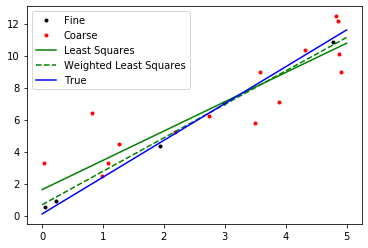

In [18]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_ls, '-g', label='Least Squares')
plt.plot(x_hat, y_wls, '--g', label='Weighted Least Squares')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

## Matrix WLS

The loss function is then:
    $$ L(\mathbf{y}, \mathbf{\hat{y}}) =  \sum_{i=1}^N w_i (y_i - (a + b x_i))^2 $$
    $$L(\mathbf{y}, \mathbf{\hat{y}}) = (\mathbf{y} - \mathbf{X \beta})^T \mathbf{W} (\mathbf{y} - \mathbf{X \beta})$$
    $$ \mathbf{W} = \begin{bmatrix}
    w_1 & 0 & \dots & 0 \\
    0 & w_2 & 0 & \vdots  \\
    \vdots & 0 & \ddots & \vdots \\
    0 & \dots & \dots & w_N 
    \end{bmatrix}$$
    
Expanding:
    $$L(\mathbf{y}, \mathbf{\hat{y}}) = \mathbf{y^T W y - y^T W X \beta - \beta^T X^T W y + \beta^T X^T W X \beta}$$

We would like to find the $\mathbf{\beta}$ that minimizes this loss function. This represents the best fit to the data.

To do this we take partial derivatives of the loss wrt to $\beta$ and set the result equal to zero:
    $$\frac{\partial L}{\partial \mathbf{\beta}} = 0$$

The derivative of the loss is:
    $$\frac{\partial L}{\partial \mathbf{\beta}} = \frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{y^T W y - y^T W X \beta - \beta^T X^T W y + \beta^T X^T W X \beta}\right)$$
    $$\frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{y^T W y} \right)=\mathbf{0}$$
    $$\frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{y^T W X \beta} \right)=\mathbf{y^T W X} = \mathbf{X^T W y} $$
    $$\frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{\beta^T X^T W y} \right)= \mathbf{X^T W y} $$
    $$\frac{\partial}{\partial \mathbf{\beta}} \left( \mathbf{\beta^T X^T W X \beta} \right) = 2 \mathbf{X^T W X \beta}$$
    
Plugging in and setting equal to zero:
    $$\frac{\partial L}{\partial \mathbf{\beta}} = -2 \mathbf{X^T W y} + 2 \mathbf{X^T W X \beta} = \mathbf{0}$$
Solving for $\mathbf{\beta}$:
    $$\mathbf{X^T W X \beta} = \mathbf{X^T W y}$$
    $$\mathbf{\beta} = \mathbf{(X^T W X)^{-1} X^T W y}$$

In [19]:
W = np.diag(w)
beta_wls = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y_obs)
y_mwls = func(x_hat, beta=beta_wls) # matrix least squares

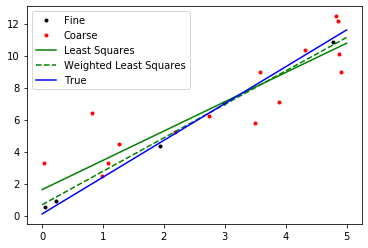

In [20]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_mls, '-g', label='Least Squares')
plt.plot(x_hat, y_mwls, '--g', label='Weighted Least Squares')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

# Stochastic Gradient Descent

Take small steps from some initial guess of params with direction determined by gradient evaluation:
$$\beta_{i+1} = \beta_i - \eta \frac{\partial}{\partial \beta} \left( L(\mathbf{y}, \mathbf{\hat{y}}) \right)$$

Loss function based on least squares
$$L(\mathbf{y}, \mathbf{\hat{y}}) = (\mathbf{y} - \mathbf{X \beta})^T (\mathbf{y} - \mathbf{X \beta})$$

Resultant expression for gradient:
$$\frac{\partial L}{\partial \mathbf{\beta}} = -2 \mathbf{X^T y} + 2 \mathbf{X^T X \beta}$$

Update initial parameter guess:

$$\beta_{i+1} = \beta_i + \eta 2 \mathbf{X^T (y-X \beta)}$$

In [21]:
# initial guess for beta
beta_gd = np.array([0, 0])

# learning rate
eta = 0.001

batch_size = 5
samples = 10000

beta_trace_gd = np.zeros((samples, beta_gd.shape[0]))
loss_trace_gd = np.zeros(samples)

for i in range(samples):
    ind = np.random.randint(0, len(x), size=batch_size)
    X_gd = np.array([X[ind[j]] for j in range(batch_size)])
    Y_gd = np.array([y_obs[ind[j]] for j in range(batch_size)])

    beta_gd = beta_gd + eta * 2* X_gd.T @ (Y_gd - X_gd @ beta_gd)

    loss_trace_gd[i] = ((y_obs - X @ beta_gd).T @  (y_obs - X @ beta_gd))
    beta_trace_gd[i] = beta_gd

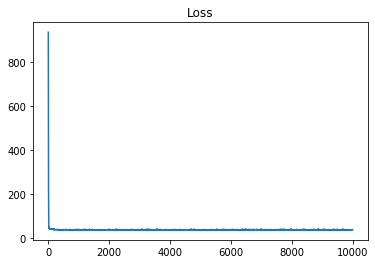

In [22]:
plt.figure()
plt.title('Loss')
plt.plot(loss_trace_gd)
plt.show()

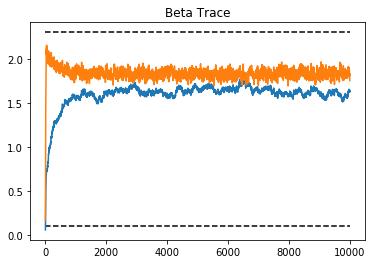

In [23]:
plt.figure()
plt.title('Beta Trace')
plt.plot(beta_trace_gd)
plt.hlines(beta_true, 0, samples, linestyle='--')
plt.show()

In [24]:
y_hat_gd = func(x_hat, beta=beta_gd)

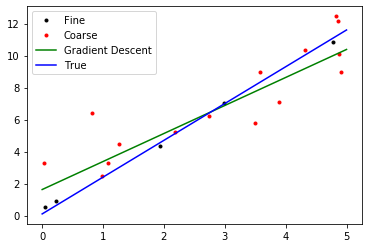

In [25]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_hat_gd, '-g', label='Gradient Descent')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

## Weighted SGD

Loss function based on least squares
$$L(\mathbf{y}, \mathbf{\hat{y}}) = (\mathbf{y} - \mathbf{X \beta})^T \mathbf{W} (\mathbf{y} - \mathbf{X \beta})$$

Resultant expression for gradient:
$$\frac{\partial L}{\partial \mathbf{\beta}} = -2 \mathbf{X^T W y} + 2 \mathbf{X^T W X \beta}$$

Update initial parameter guess:

$$\beta_{i+1} = \beta_i + \eta 2 \mathbf{X^T W (y-X \beta)}$$

In [26]:
# initial guess for beta
beta_wgd = np.array([0, 0])

# learning rate
eta = 0.001

batch_size = 5
samples = 10000

beta_trace_wgd = np.zeros((samples, beta_wgd.shape[0]))
loss_trace_wgd = np.zeros(samples)

for i in range(samples):
    ind = np.random.randint(0, len(x), size=batch_size)
    X_wgd = np.array([X[ind[j]] for j in range(batch_size)])
    Y_wgd = np.array([y_obs[ind[j]] for j in range(batch_size)])
    w_wgd = np.array([w[ind[j]] for j in range(batch_size)])
    W_wgd = np.diag(w_wgd)

    beta_wgd = beta_wgd + eta * 2* X_wgd.T @ W_wgd @ (Y_wgd - X_wgd @ beta_wgd)

    loss_trace_wgd[i] = ((y_obs - X @ beta_wgd).T @ W @ (y_obs - X @ beta_wgd))
    beta_trace_wgd[i] = beta_wgd

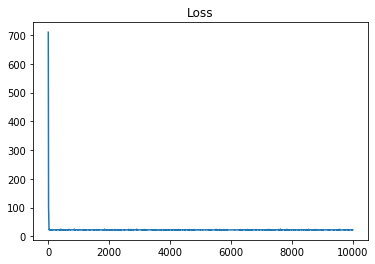

In [27]:
plt.figure()
plt.title('Loss')
plt.plot(loss_trace_wgd)
plt.show()

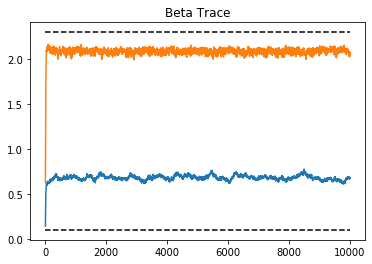

In [28]:
plt.figure()
plt.title('Beta Trace')
plt.plot(beta_trace_wgd)
plt.hlines(beta_true, 0, samples, linestyle='--')
plt.show()

In [29]:
y_hat_wgd = func(x_hat, beta=beta_wgd)

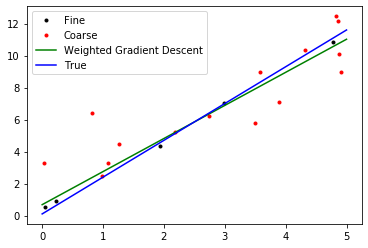

In [30]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_hat_wgd, '-g', label='Weighted Gradient Descent')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

# Scipi.optimize

In [31]:
# want to minimize a loss
def loss(beta):
    loss = (y_obs - X @ beta).T @ (y_obs - X @ beta)
    print(loss)
    return loss

def weighted_loss(beta):
    loss = (y_obs - X @ beta).T @ W @ (y_obs - X @ beta)
    print(loss)
    return loss

In [32]:
opt = scipy.optimize.minimize(loss, np.array([1,1]))
beta_sls = opt.x # beta for scipy with least squares loss

241.99929860343633
241.99929690144427
241.9992925111899
241.99929860343633
38.123624260067466
38.123624260067466
38.123624280728784
38.123624575867225
116.37015901436504
116.37015901436504
116.37015961697769
116.37015884601274
37.25550140977443
37.25550140977443
37.25550148561604
37.25550167966715
36.85308692230862
36.85308692230862
36.853086918427316
36.8530869084965
36.852030219153946
36.852030219153946
36.852030219153946
36.85203021915396


In [33]:
y_hat_sls = func(x_hat, beta=beta_sls)

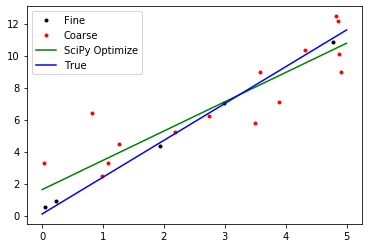

In [34]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_hat_sls, '-g', label='SciPy Optimize')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

In [35]:
opt_w = scipy.optimize.minimize(weighted_loss, np.array([1,1]))
beta_swls = opt_w.x # beta for scipy with weighted loss

287.9628429156183
287.96284089668086
287.96283505739405
287.9628429156183
27.188322753840612
27.188322753840612
27.18832307084271
27.188323104688504
2188.468962855698
2188.468962855698
2188.4689582027945
2188.4689640511233
23.033758039254497
23.033758039254497
23.03375814770173
23.033758425543844
22.39449396865682
22.39449396865682
22.394493967920923
22.394493966035537
22.394464529571625
22.394464529571625
22.394464529571625
22.394464529571614


In [36]:
y_hat_swls = func(x_hat, beta=beta_swls)

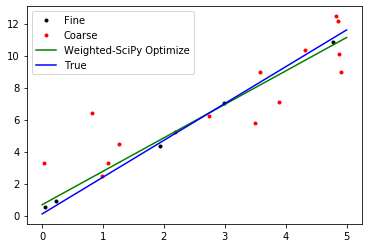

In [37]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_hat_swls, '-g', label='Weighted-SciPy Optimize')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

# Homoscedastic Bayes

Bayes math here

In [38]:
import pymc3 as pm
import arviz as az

In [39]:
model = pm.Model()

with model:
    # Priors
    a_mcmc = pm.Flat("a_mcmc")
    b_mcmc = pm.Flat("b_mcmc")
    sigma_mcmc = pm.HalfFlat("sigma_mcmc")
    
    # Model
    y_pred_mcmc = a_mcmc + b_mcmc*x
    
    # Likelihood
    y_obs_mcmc = pm.Normal("y_obs_mcmc", mu=y_pred_mcmc, sigma=sigma_mcmc, observed=y_obs)    

In [40]:
with model:
    trace_1 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_mcmc, b_mcmc, a_mcmc]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:25<00:00, 1656.58draws/s]
The acceptance probability does not match the target. It is 0.8883918849828583, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850205467351483, but should be close to 0.8. Try to increase the number of tuning steps.


/packages/python/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/packages/python/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/packages/python/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


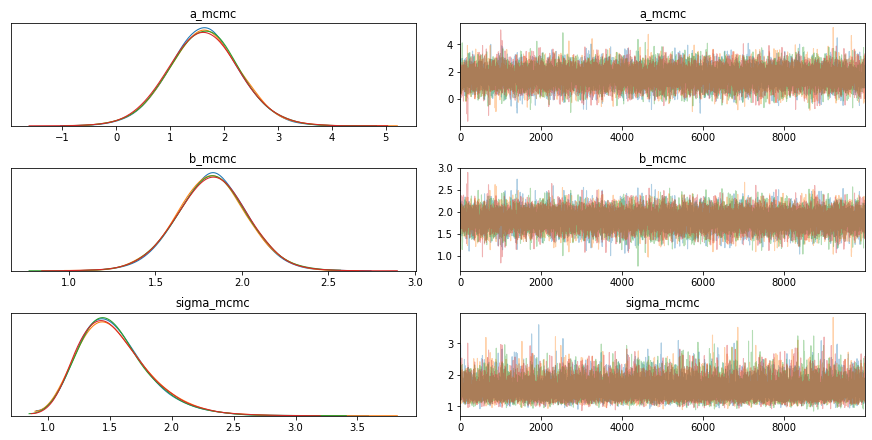

In [41]:
with model:
    az.plot_trace(trace_1)

In [42]:
a_hpd = pm.hpd(trace_1['a_mcmc'])
b_hpd = pm.hpd(trace_1['b_mcmc'])

a_mean = trace_1['a_mcmc'].mean()
b_mean = trace_1['b_mcmc'].mean()

y_hat_mcmc = a_mean + b_mean*x_hat
y_lo = a_hpd[0] + b_hpd[0]*x_hat
y_hi = a_hpd[1] + b_hpd[1]*x_hat

print(a_mean, a_ls)
print(b_mean, b_ls)

1.6310509653997838 1.6217381508530337
1.8271443873202509 1.8298534393823445


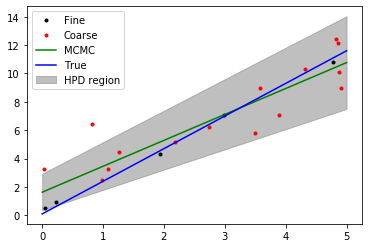

In [43]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_hat_mcmc, '-g', label='MCMC')
plt.plot(x_hat, y_true, '-b', label='True')
plt.fill_between(x=x_hat, y1=y_lo, y2=y_hi, alpha=0.5, color='grey', label='HPD region')
plt.legend(loc=0)
plt.show()

# Hetoroscedastic Bayes

More math here

In [44]:
weighted_model = pm.Model()

with weighted_model:
    # Priors
    a_wmcmc = pm.Flat("a_wmcmc")
    b_wmcmc = pm.Flat("b_wmcmc")
    
    # Model
    y_pred_wmcmc = a_wmcmc + b_wmcmc*x
    
    # Likelihood
    y_obs_wmcmc = pm.Normal("y_obs_mcmc", mu=y_pred_wmcmc, sigma=sigma, observed=y_obs) 

In [45]:
with weighted_model:
    trace_2 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_wmcmc, a_wmcmc]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:23<00:00, 1797.26draws/s]
The acceptance probability does not match the target. It is 0.8947174109572459, but should be close to 0.8. Try to increase the number of tuning steps.


/packages/python/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/packages/python/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


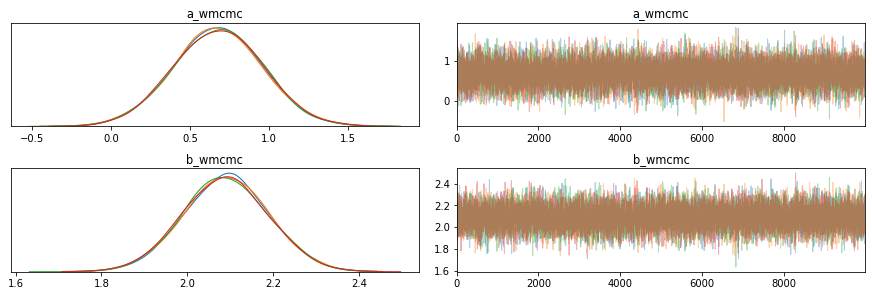

In [46]:
with weighted_model:
    az.plot_trace(trace_2)

In [47]:
a_whpd = pm.hpd(trace_2['a_wmcmc'])
b_whpd = pm.hpd(trace_2['b_wmcmc'])

a_wmean = trace_2['a_wmcmc'].mean()
b_wmean = trace_2['b_wmcmc'].mean()

y_hat_wmcmc = a_wmean + b_wmean*x_hat
y_wlo = a_whpd[0] + b_whpd[0]*x_hat
y_whi = a_whpd[1] + b_whpd[1]*x_hat

print(a_wmean, a_wls)
print(b_wmean, b_wls)

0.6771655107569557 0.6766774091723944
2.0904491237691034 2.0902364330760514


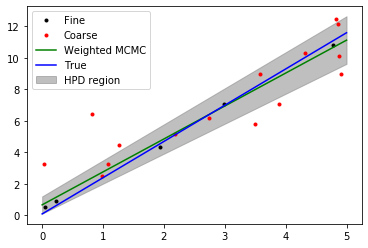

In [48]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_hat_wmcmc, '-g', label='Weighted MCMC')
plt.plot(x_hat, y_true, '-b', label='True')
plt.fill_between(x=x_hat, y1=y_wlo, y2=y_whi, alpha=0.5, color='grey', label='HPD region')
plt.legend(loc=0)
plt.show()

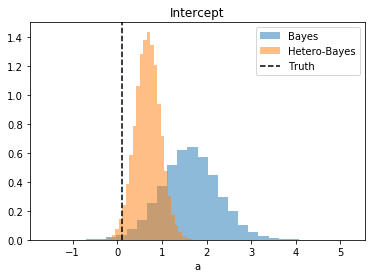

In [63]:
plt.figure()
plt.title('Intercept')
plt.hist(trace_1['a_mcmc'], bins=30, alpha=0.5, density=True, label='Bayes')
plt.hist(trace_2['a_wmcmc'], bins=30, alpha=0.5, density=True, label='Hetero-Bayes')
plt.xlabel('a')
plt.ylim([0, 1.5])
plt.vlines(intercept, 0, 2, linestyles='--', label='Truth')
plt.legend(loc=0)
plt.show()


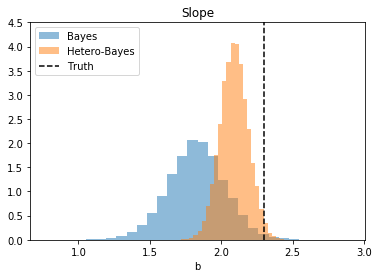

In [62]:
plt.figure()
plt.title('Slope')
plt.hist(trace_1['b_mcmc'], bins=30, alpha=0.5, density=True, label='Bayes')
plt.hist(trace_2['b_wmcmc'], bins=30, alpha=0.5, density=True, label='Hetero-Bayes')
plt.xlabel('b')
plt.ylim([0, 4.5])
plt.vlines(slope, 0, 5, linestyles='--', label='Truth')
plt.legend(loc=2)
plt.show()


# Evolutionary Algorithm

In [49]:
def loss(y_obs, X, a, b):
    beta = np.array([a, b])
    loss = (y_obs - X @ beta).T @  (y_obs - X @ beta)
    return loss

In [50]:
a_ea = 0
b_ea = 0

samples = 1000

a_ea_trace = np.zeros(samples)
a_loss_trace = np.zeros(samples)

b_ea_trace = np.zeros(samples)
b_loss_trace = np.zeros(samples)

num_off = 5

for i in range(samples):
    a_off = np.random.normal(loc=a_ea, scale=0.05, size=num_off)
    b_off = np.random.normal(loc=b_ea, scale=0.05, size=num_off)

    a_loss = np.array([loss(y_obs, X, a_off[j], b_ea) for j in range(num_off)])
    a_ea = a_off[a_loss.argmin()]
    a_ea_trace[i] = a_ea
    a_loss_trace[i] = a_loss[a_loss.argmin()]

    b_loss = np.array([loss(y_obs, X, a_ea, b_off[j]) for j in range(num_off)])
    b_ea = b_off[b_loss.argmin()]
    b_ea_trace[i] = b_ea
    b_loss_trace[i] = b_loss[b_loss.argmin()]

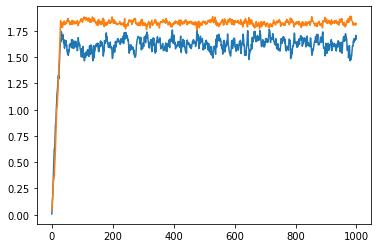

In [51]:
plt.figure()
plt.plot(a_ea_trace)
plt.plot(b_ea_trace)
plt.show()

In [52]:
y_hat_ea = func(x_hat, beta=np.array([a_ea, b_ea]))

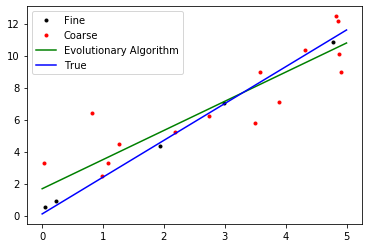

In [53]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_hat_ea, '-g', label='Evolutionary Algorithm')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()

## Weighted Loss EA

In [54]:
def weighted_loss(y_obs, X, W, a, b):
    beta = np.array([a, b])
    loss = (y_obs - X @ beta).T @ W @ (y_obs - X @ beta)
    return loss

In [55]:
a_wea = 0
b_wea = 0

samples = 1000

a_wea_trace = np.zeros(samples)
a_wloss_trace = np.zeros(samples)

b_wea_trace = np.zeros(samples)
b_wloss_trace = np.zeros(samples)

num_off = 5

for i in range(samples):
    a_off = np.random.normal(loc=a_wea, scale=0.05, size=num_off)
    b_off = np.random.normal(loc=b_wea, scale=0.05, size=num_off)

    a_loss = np.array([weighted_loss(y_obs, X, W, a_off[j], b_wea) for j in range(num_off)])
    a_wea = a_off[a_loss.argmin()]
    a_wea_trace[i] = a_wea
    a_wloss_trace[i] = a_loss[a_loss.argmin()]

    b_loss = np.array([weighted_loss(y_obs, X, W, a_wea, b_off[j]) for j in range(num_off)])
    b_wea = b_off[b_loss.argmin()]
    b_wea_trace[i] = b_wea
    b_wloss_trace[i] = b_loss[b_loss.argmin()]

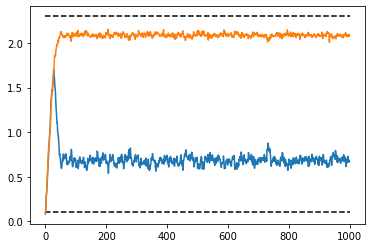

In [56]:
plt.figure()
plt.plot(a_wea_trace)
plt.plot(b_wea_trace)
plt.hlines(beta_true, 0, samples, linestyle='--')
plt.show()

In [57]:
y_hat_wea = func(x_hat, beta=np.array([a_wea, b_wea]))

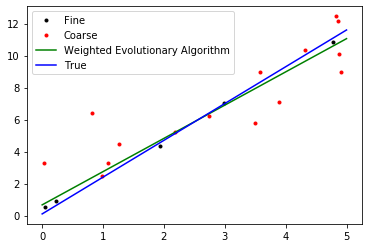

In [58]:
plt.figure()
plt.plot(x_fine, y_fine, 'k.', label='Fine')
plt.plot(x_coarse, y_coarse, 'r.', label='Coarse')
plt.plot(x_hat, y_hat_wea, '-g', label='Weighted Evolutionary Algorithm')
plt.plot(x_hat, y_true, '-b', label='True')
plt.legend(loc=0)
plt.show()